Link: https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas,numpy, string #, xgboost #textblob, string#,# xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline

ModuleNotFoundError: No module named 'xgboost'

In [2]:
DATA_DIR = "../../data/raw/"
INPUT_FILE_NAME = 'cleaned_squashed.parquet'

In [3]:
df = pd.read_parquet(DATA_DIR + INPUT_FILE_NAME)
df.head()

,speaker,headline,description,duration,tags,transcript,WC,clean_transcript,clean_transcript_string,squash_tags
0,Al Gore,Averting the climate crisis,With the same humor and humanity he exuded in ...,0:16:17,"cars,alternative energy,culture,politics,scien...","0:14\r\r\rThank you so much, Chris.\rAnd it's ...",2281.0,"[thank, chris, truly, great, honor, opportunit...",thank chris truly great honor opportunity come...,"alternative energy,culture,politics,science,cl..."
1,Amy Smith,Simple designs to save a life,Fumes from indoor cooking fires kill more than...,0:15:06,"MacArthur grant,simplicity,industrial design,a...","0:11\r\r\rIn terms of invention,\rI'd like to ...",2687.0,"[term, invention, like, tell, tale, favorite, ...",term invention like tell tale favorite project...,"industrial design,alternative energy,invention..."
2,Ashraf Ghani,How to rebuild a broken state,Ashraf Ghani's passionate and powerful 10-minu...,0:18:45,"corruption,poverty,economics,investment,milita...","0:12\r\r\rA public, Dewey long ago observed,\r...",2506.0,"[public, dewey, long, ago, observe, constitute...",public dewey long ago observe constitute discu...,"poverty,economics,investment,culture,politics,..."
3,Burt Rutan,The real future of space exploration,"In this passionate talk, legendary spacecraft ...",0:19:37,"aircraft,flight,industrial design,NASA,rocket ...","0:11\r\r\rI want to start off by saying, Houst...",3092.0,"[want, start, say, houston, problem, enter, se...",want start say houston problem enter second ge...,"industrial design,invention,engineering,entrep..."
4,Chris Bangle,Great cars are great art,American designer Chris Bangle explains his ph...,0:20:04,"cars,industrial design,transportation,inventio...","0:12\r\r\rWhat I want to talk about is, as bac...",3781.0,"[want, talk, background, idea, car, art, actua...",want talk background idea car art actually mea...,"industrial design,transportation,invention,des..."


In [30]:
def print_full_dataframe(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [37]:
def compute_tag_ratio(target_column, df=df):
    tags = df[target_column].str.replace(', ',',').str.lower().str.strip()
    split_tags = tags.str.split(',')
    tag_counts_per_talk = split_tags.apply(len)

    joined_tags = tags.str.cat(sep=',').split(',')
    all_tags = pd.Series(joined_tags)

    tag_counts = all_tags.value_counts().rename_axis(target_column).reset_index(name='counts')
    tag_counts['no_count'] = len(df)-tag_counts['counts']
    tag_counts['ratio'] = tag_counts['counts']/tag_counts['no_count']
    tag_counts['overall_ratio'] = tag_counts['counts']/(tag_counts['no_count'] + tag_counts['counts'])
    return tag_counts

print(compute_tag_ratio('tags', df))
squashed_tag_counts = compute_tag_ratio('squash_tags', df)
print_full_dataframe(squashed_tag_counts)

               tags  counts  no_count     ratio  overall_ratio
0        technology     695      1691  0.410999       0.291282
1           science     522      1864  0.280043       0.218776
2     global issues     483      1903  0.253810       0.202431
3           culture     470      1916  0.245303       0.196982
4            design     400      1986  0.201410       0.167645
..              ...     ...       ...       ...            ...
413             gay       1      2385  0.000419       0.000419
414      blockchain       1      2385  0.000419       0.000419
415  ted en español       1      2385  0.000419       0.000419
416        asteroid       1      2385  0.000419       0.000419
417                       1      2385  0.000419       0.000419

[418 rows x 5 columns]
            squash_tags  counts  no_count     ratio  overall_ratio
0            technology     695      1691  0.410999       0.291282
1               science     522      1864  0.280043       0.218776
2         global is

In [21]:
all_tags = list(squashed_tag_counts.squash_tags.unique())
print(all_tags)

['technology', 'science', 'global issues', 'culture', 'design', 'tedx', 'business', 'entertainment', 'health', 'innovation', 'education', 'art', 'society', 'social change', 'communication', 'politics', 'future', 'biology', 'creativity', 'humanity', 'collaboration', 'environment', 'medicine', 'economics', 'brain', 'activism', 'invention', 'community', 'history', 'children', 'ted fellows', 'health care', 'music', 'women', 'cities', 'storytelling', 'animals', 'war', 'engineering', 'leadership', 'identity', 'nature', 'computers', 'psychology', 'humor', 'life', 'performance', 'exploration', 'africa', 'data', 'photography', 'inequality', 'medical research', 'personal growth', 'neuroscience', 'government', 'climate change', 'visualizations', 'internet', 'architecture', 'sustainability', 'oceans', 'disease', 'green', 'happiness', 'biotech', 'potential', 'work', 'physics', 'media', 'film', 'violence', 'evolution', 'mind', 'big problems', 'writing', 'motivation', 'philosophy', 'biodiversity', 'l

In [22]:
def create_one_hot_encode(transcript_column, tag_column, unique_tags, df=df):
    complete_transcripts_tags = []
    for rows, value in df.iterrows():
        one_hot_encoding = [0] * len(all_tags)
        transcript = [value[transcript_column]]
        indiv_tags = value[tag_column].split(',')
        for tags in indiv_tags:
            if tags == '':
                continue
            index = unique_tags.index(tags.lower().lstrip(' '))
            one_hot_encoding[index] = 1
        indiv_transcript_tags = transcript + one_hot_encoding
        complete_transcripts_tags.append(indiv_transcript_tags)
    return pd.DataFrame(complete_transcripts_tags, columns=['transcript'] + all_tags)

In [29]:
ted_tags = create_one_hot_encode('clean_transcript_string', 'squash_tags', all_tags)
ted_tags

,transcript,technology,science,global issues,culture,design,tedx,business,entertainment,health,...,industrial design,urban planning,empathy,united states,code,asia,depression,planets,bacteria,faith
0,thank chris truly great honor opportunity come...,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,term invention like tell tale favorite project...,0,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,public dewey long ago observe constitute discu...,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,want start say houston problem enter second ge...,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,want talk background idea car art actually mea...,1,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2381,imagine walk even discover everybody room look...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2382,pay close attention easy attention pull differ...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2383,happy pic take senior college right dance prac...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2384,sevenyearold grandson sleep hall wake lot morn...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
def get_target_column(target_tag, df=ted_tags):
    return df[['transcript', target_tag]]
single_class = get_target_column('technology', ted_tags)

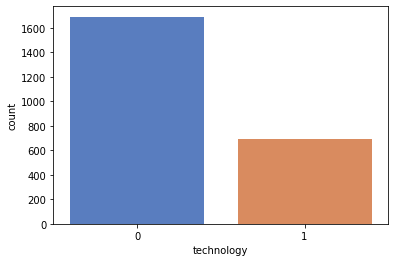

In [34]:
#breakdown by class
sns.countplot(x="technology", data=single_class, palette="muted");

In [35]:
single_class.dtypes

transcript    object
technology     int64
dtype: object

In [46]:
def train_test_split(target_tag, df=ted_tags):
    train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['transcript'], df[target_tag])
    return train_x, valid_x, train_y, valid_y 

In [50]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = train_test_split('technology')

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [51]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(single_class['transcript'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [52]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(single_class['transcript'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(single_class['transcript'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(single_class['transcript'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

In [53]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y), classifier

In [54]:
# Naive Bayes on Count Vectors
accuracy, classifier_count = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print ("NB, Count Vectors: {}".format(accuracy))

# Naive Bayes on Word Level TF IDF Vectors
accuracy, classifier_word_tfidf = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("NB, WordLevel TF-IDF: {}".format(accuracy))

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy, classifier_ngram_tfidf = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("NB, N-Gram Vectors: {}".format(accuracy))

# Naive Bayes on Character Level TF IDF Vectors
accuracy, classifier_charlevel_tfidf = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("NB, CharLevel Vectors: {}".format(accuracy))

NB, Count Vectors: 0.7638190954773869
NB, WordLevel TF-IDF: 0.7587939698492462
NB, N-Gram Vectors: 0.7219430485762144
NB, CharLevel Vectors: 0.7068676716917923


In [55]:
# Linear Classifier on Count Vectors
accuracy, classifier_count = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print ("LR, Count Vectors: {}".format(accuracy))

# Linear Classifier on Word Level TF IDF Vectors
accuracy, classifier_word_tfidf = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("LR, WordLevel TF-IDF: {}".format(accuracy))

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy, classifier_ngram_tfidf = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("LR, N-Gram Vectors: {}".format(accuracy))

# Linear Classifier on Character Level TF IDF Vectors
accuracy, classifier_charlevel_tfidf = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("LR, CharLevel Vectors: {}".format(accuracy))

C:\Users\Glenn\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR, Count Vectors: 0.7453936348408711
LR, WordLevel TF-IDF: 0.7788944723618091
LR, N-Gram Vectors: 0.7236180904522613
LR, CharLevel Vectors: 0.7403685092127303


In [57]:
accuracy, classifier_ngram_tfidf = train_model(svm.SVC(kernel='linear', class_weight='balanced', C=1.0), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("SVM, N-Gram Vectors: {}".format(accuracy))

SVM, N-Gram Vectors: 0.7420435510887772


In [60]:
# RF on Count Vectors
accuracy, classifier_count = train_model(ensemble.RandomForestClassifier(class_weight='balanced'), xtrain_count, train_y, xvalid_count)
print ("RF, Count Vectors: {}".format(accuracy))

# RF on Word Level TF IDF Vectors
accuracy, classifier_word_tfidf = train_model(ensemble.RandomForestClassifier(class_weight='balanced'), xtrain_tfidf, train_y, xvalid_tfidf)
print ("RF, WordLevel TF-IDF: {}".format(accuracy))

C:\Users\Glenn\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, Count Vectors: 0.7370184254606366


C:\Users\Glenn\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, WordLevel TF-IDF: 0.7520938023450586


In [61]:
# Extereme Gradient Boosting on Count Vectors
accuracy, classifier_count = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print ("Xgb, Count Vectors: {}".format(accuracy))

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy, classifier_word_tfidf = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print ("Xgb, WordLevel TF-IDF: {}".format(accuracy))

# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy, classifier_word_tfidf  = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print ("Xgb, CharLevel Vectors: {}".format(accuracy))

NameError: name 'xgboost' is not defined

In [1]:
# model_pipeline = Pipeline(steps = [
#     ('target_column', get_target_column(target_tag='technology', df=ted_tags)),
#     ('tts', train_test_split(target_tag='technology'))
# ])
